# ENEL 645 - Final Project - Auto-Keras

# Mount Google Drive 

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
#Check Ram
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


# Check GPU

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Apr  2 22:22:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    32W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

##Installs

In [ ]:
%%capture
!pip install git+https://github.com/keras-team/keras-tuner.git
!pip install autokeras

##Imports

In [ ]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import glob
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
import autokeras as ak
import shutil
from IPython.display import Image

#Analyzing Dataset

## Display Labels

In [ ]:
labels_csv = pd.read_csv("/content/drive/MyDrive/enel645_project/dog-breed-identification/labels.csv")

print(labels_csv.describe())
labels_csv.describe()
labels_csv

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
...,...,...
10217,ffd25009d635cfd16e793503ac5edef0,borzoi
10218,ffd3f636f7f379c51ba3648a9ff8254f,dandie_dinmont
10219,ffe2ca6c940cddfee68fa3cc6c63213f,airedale
10220,ffe5f6d8e2bff356e9482a80a6e29aac,miniature_pinscher


## View image sample

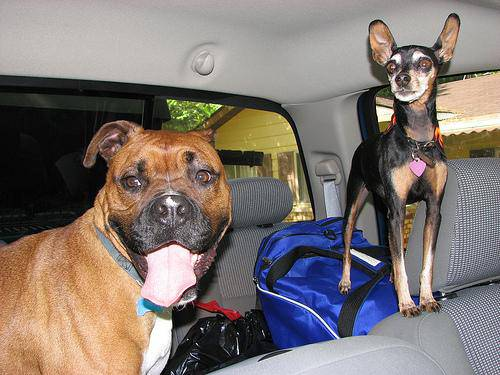

In [ ]:
Image("/content/drive/MyDrive/enel645_project/dog-breed-identification/train/ffe5f6d8e2bff356e9482a80a6e29aac.jpg")

## Create path names from image IDs

In [ ]:
filenames = ["/content/drive/MyDrive/enel645_project/dog-breed-identification/train/" + fname + ".jpg" for fname in labels_csv["id"]]

## Check if number of filenames matches number of images

In [ ]:
if len(os.listdir("/content/drive/MyDrive/enel645_project/dog-breed-identification/train/")) != len(filenames):
  print("Mismatched number of filenames and files, check target directory.")
else:
  print("Identical number of filenames and files.")

Identical number of filenames and files.


In [ ]:
labels = labels_csv["breed"]
labels

0                     boston_bull
1                           dingo
2                        pekinese
3                        bluetick
4                golden_retriever
                   ...           
10217                      borzoi
10218              dandie_dinmont
10219                    airedale
10220          miniature_pinscher
10221    chesapeake_bay_retriever
Name: breed, Length: 10222, dtype: object

## Check for missing files

In [ ]:
if len(labels) == len(filenames):
  print("Number of labels matches number of filenames")
else:
  print("Number of labels does not match numbe of filenames")

Number of labels matches number of filenames


## Set number of images to use for experimentation

In [ ]:
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:1}

## Rename DF

In [ ]:
df = labels_csv

In [ ]:
df["id"] = [fname + ".jpg" for fname in df["id"]]
df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07.jpg,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97.jpg,dingo
2,001cdf01b096e06d78e9e5112d419397.jpg,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d.jpg,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62.jpg,golden_retriever


## Preparing Train and Validation Data

In [ ]:
BATCH_SIZE = 32 #@param {type:"slider", min:0, max:100, step:1}
IMG_SIZE = 224

In [ ]:
gen_params = {"featurewise_center":False,
              "samplewise_center":False,
              "featurewise_std_normalization":False,\
              "samplewise_std_normalization":False,
              "zca_whitening":False,
              "rotation_range":20,
              "width_shift_range":0.1,
              "height_shift_range":0.1,\
              "shear_range":0.2, 
              "zoom_range":0.1,
              "horizontal_flip":True,
              "fill_mode":'constant',\
               "cval": 0}
datagen = ImageDataGenerator(**gen_params, validation_split=0.2, preprocessing_function = tf.keras.applications.resnet.preprocess_input)

In [ ]:
train_generator = datagen.flow_from_dataframe(
                        dataframe = df,
                        directory = "/content/drive/MyDrive/enel645_project/dog-breed-identification/train/",
                        x_col="id",
                        y_col="breed",
                        subset="training",
                        batch_size=BATCH_SIZE,
                        seed=42,
                        shuffle=True,
                        class_mode="sparse",
                        color_mode = "rgb",
                        target_size=(IMG_SIZE, IMG_SIZE))

Found 8178 validated image filenames belonging to 120 classes.


In [ ]:
validation_generator = datagen.flow_from_dataframe(
                        dataframe = df,
                        directory = "/content/drive/MyDrive/enel645_project/dog-breed-identification/train/",
                        x_col="id",
                        y_col="breed",
                        subset="validation",
                        batch_size=BATCH_SIZE,
                        seed=42,
                        interpolation='nearest',
                        shuffle=True,
                        class_mode="sparse",
                        color_mode = "rgb",
                        target_size=(IMG_SIZE, IMG_SIZE))

Found 2044 validated image filenames belonging to 120 classes.


#Visualize the data

In [ ]:
class_name = [name for name in train_generator.class_indices.keys()]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

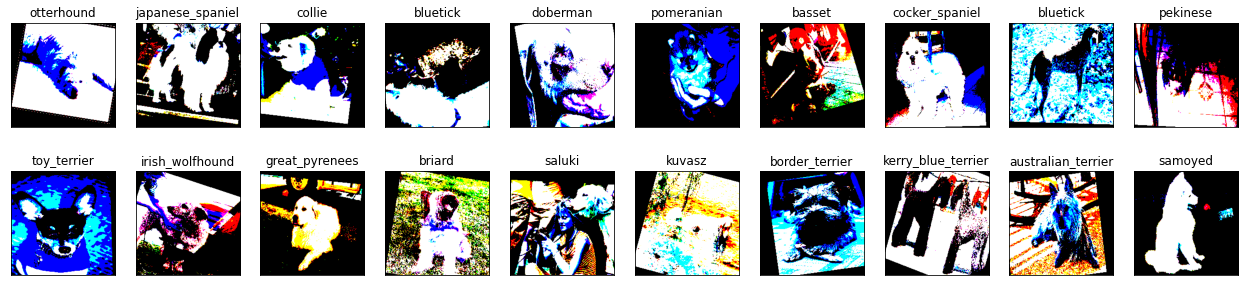

In [ ]:
images, labels = next(iter(train_generator))

fig = plt.figure(figsize=(22, 5))

for i in np.arange(20):
  ax = fig.add_subplot(2, 10, i+1, xticks=[], yticks=[])
  plt.imshow(images[i])
  ax.set_title(class_name[int(labels[i])])

##Prepare test Data 

In [ ]:
test_files = []
for files in os.listdir("/content/drive/MyDrive/enel645_project/dog-breed-identification/test/"):
  test_files.append(files)
test_files[:10]

['e646ac89e0832502f9a726c72773cfcc.jpg',
 'e5ad4cc7818e4eed04d209da177afa6f.jpg',
 'e17defebd1b8fc39e9c3c10df3c2e3de.jpg',
 'e1c6c50bbaee219e7faf29e9c1c343ca.jpg',
 'dcd3cfe0cd6d363a3ed21639c434c8d3.jpg',
 'e0bf90705facb623a6f36046cc495659.jpg',
 'e3f04efb648b110b2eb04b9c041504d8.jpg',
 'e1f9be3ecf0409189486c786ff4bd65a.jpg',
 'df645ae75554d4d7130bfa1b72be53ce.jpg',
 'e702ddff98bd0b05ab200ffb43fb080a.jpg']

In [ ]:
test_df = pd.DataFrame()
test_df["test_files"] = test_files
test_df.head()

,test_files
0,e646ac89e0832502f9a726c72773cfcc.jpg
1,e5ad4cc7818e4eed04d209da177afa6f.jpg
2,e17defebd1b8fc39e9c3c10df3c2e3de.jpg
3,e1c6c50bbaee219e7faf29e9c1c343ca.jpg
4,dcd3cfe0cd6d363a3ed21639c434c8d3.jpg


In [ ]:
test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
                            dataframe=test_df,
                            directory="/content/drive/MyDrive/enel645_project/dog-breed-identification/test/",
                            x_col="test_files",
                            y_col=None,
                            shuffle=False,
                            color_mode = "rgb",
                            target_size=(IMG_SIZE, IMG_SIZE),
                            class_mode=None)

Found 10357 validated image filenames.


In [ ]:
train_dataset = ("/content/drive/MyDrive/enel645_project/dog-breed-identification/train/")
test_dataset =  ("/content/drive/MyDrive/enel645_project/dog-breed-identification/test/")

In [ ]:
height, width, pixel_val = train_generator.image_shape
print("Number of training samples:", train_generator.samples)
print("Shape of training samples:", train_generator.image_shape)
print("Height of training samples:", height)
print("Width of training samples:", width)
print("Pixel RGB:", pixel_val)

Number of training samples: 8178
Shape of training samples: (224, 224, 3)
Height of training samples: 224
Width of training samples: 224
Pixel RGB: 3


## AutoML - Auto-Keras

In [ ]:
image_input_dimensions_3d = (224,224,3)
image_input_dimensions_2d = (224,224)
image_height = 224
image_width = 224
batch_size = 32
seed = 32

In [ ]:
train_folder = "/content/drive/MyDrive/enel645_project/dog-breed-identification/train2/"
test_folder = "/content/drive/MyDrive/enel645_project/dog-breed-identification/test_2/"

In [ ]:
labels_csv

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07.jpg,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97.jpg,dingo
2,001cdf01b096e06d78e9e5112d419397.jpg,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d.jpg,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62.jpg,golden_retriever
...,...,...
10217,ffd25009d635cfd16e793503ac5edef0.jpg,borzoi
10218,ffd3f636f7f379c51ba3648a9ff8254f.jpg,dandie_dinmont
10219,ffe2ca6c940cddfee68fa3cc6c63213f.jpg,airedale
10220,ffe5f6d8e2bff356e9482a80a6e29aac.jpg,miniature_pinscher


##Create Directories for each class in Google Drive

In [ ]:
subfolder_names = class_name
for subfolder_name in subfolder_names:
    os.makedirs(os.path.join(train_folder, subfolder_name))

In [ ]:
for index, row in labels_csv.iterrows():
    filename = row["id"]
    breed = row["breed"]
    (shutil.copy(("/content/drive/MyDrive/enel645_project/dog-breed-identification/train/" + filename), ("/content/drive/MyDrive/enel645_project/dog-breed-identification/train2/" + breed + "/" + filename)))

##Training and Validation Data From Directories

In [ ]:
train_data = ak.image_dataset_from_directory(
    directory=train_folder,
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=(224, 224),
    batch_size=batch_size,
)

validation_data = ak.image_dataset_from_directory(
    train_folder,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=(224, 224),
    batch_size=batch_size,
)

Found 10222 files belonging to 120 classes.
Using 8178 files for training.
Found 10222 files belonging to 120 classes.
Using 2044 files for validation.


In [ ]:
clf = ak.ImageClassifier(max_trials=3)

##Fit Auto-Keras

In [ ]:
clf.fit(train_data, validation_data=validation_data, epochs=10)

Trial 3 Complete [01h 00m 57s]
val_loss: 0.6391048431396484

Best val_loss So Far: 0.6391048431396484
Total elapsed time: 01h 26m 32s
INFO:tensorflow:Oracle triggered exit
Epoch 1/10
Not enough memory, reduce batch size to 16.
Epoch 1/10
512/512 [==============================] - 353s 689ms/step - loss: 4.4849 - accuracy: 0.1138 - val_loss: 4.4105 - val_accuracy: 0.1208
Epoch 2/10
512/512 [==============================] - 348s 679ms/step - loss: 2.8640 - accuracy: 0.5061 - val_loss: 2.0409 - val_accuracy: 0.7040
Epoch 3/10
512/512 [==============================] - 348s 678ms/step - loss: 1.5191 - accuracy: 0.7002 - val_loss: 1.1851 - val_accuracy: 0.7911
Epoch 4/10
512/512 [==============================] - 349s 680ms/step - loss: 0.9109 - accuracy: 0.8070 - val_loss: 0.9093 - val_accuracy: 0.8121
Epoch 5/10
512/512 [==============================] - 348s 679ms/step - loss: 0.5991 - accuracy: 0.8799 - val_loss: 0.7879 - val_accuracy: 0.8209
Epoch 6/10
512/512 [=======================

##Export Auto-Keras Model

In [ ]:
model = clf.export_model()

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 cast_to_float32 (CastToFloa  (None, 224, 224, 3)      0         
 t32)                                                            
                                                                 
 normalization (Normalizatio  (None, 224, 224, 3)      7         
 n)                                                              
                                                                 
 random_translation (RandomT  (None, 224, 224, 3)      0         
 ranslation)                                                     
                                                                 
 random_flip (RandomFlip)    (None, 224, 224, 3)       0         
                                                             